<a href="https://colab.research.google.com/github/MarianaSaenz/deep_learning/blob/main/sequence_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras --upgrade --quiet
!pip install tensorflow --upgrade --quiet
!pip install scikeras --quiet
!pip install keras-tuner --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2

In [ ]:
### import modules
import json
from math import e
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import BackupAndRestore, History, ModelCheckpoint
from keras.layers import Dense
from keras.models import Sequential
from keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob, iglob
import tensorflow as tf
import os
from os.path import basename, isdir
import keras.applications.resnet50 as resnet50
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, top_k_accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, GlobalAveragePooling2D, Input
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.metrics import F1Score
#import tensorflow_datasets as tfds
#from PIL import Image
import pathlib
import pickle
from keras.applications.resnet50 import preprocess_input, decode_predictions
import gc
from keras import backend as K
import keras_tuner as kt
import os
from keras import activations
#import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import time
from datetime import datetime



In [ ]:
np.random.seed(4)
keras.utils.set_random_seed(4)
#random.seed(4)
tf.random.set_seed(4)


In [ ]:
### connect to drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#dir_path = '/content/drive/MyDrive/DLProject/'
dir_path = '/content/drive/MyDrive/MSc/DL/DLProject/'
os.chdir(dir_path)

In [ ]:
# Functions
def plot_metrics(history):
  metrics = ['loss', 'f1_score']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, 1])
    elif metric == 'f1_score':
      plt.ylim([0.,1])
    else:
      plt.ylim([0,0.2])

    plt.legend()

def create_checkpoint_paths():
  current_datetime = datetime.now().strftime("%d_%H:%M")
  checkpoint_folder = f'/content/drive/MyDrive/DLProject/cnn_models/weights_model_{current_datetime}/'
  os.makedirs(checkpoint_folder)

  checkpoint_path = os.path.join(checkpoint_folder, 'cp_model.weights.h5')
  epoch_checkpoint_path = os.path.join(checkpoint_folder, 'cp_model_with_epoch.weights.h5')
  metrics_path = os.path.join(checkpoint_folder, 'metrics_per_epoch_callback.txt')

  return checkpoint_folder, checkpoint_path, epoch_checkpoint_path, metrics_path

In [ ]:
# callback: save metrics

class SaveMetricsCallback(keras.callbacks.Callback):
    def __init__(self, file_path):
        super(SaveMetricsCallback, self).__init__()
        self.file_path = file_path

    def on_epoch_end(self, epoch, logs=None):
        with open(self.file_path, 'a') as f:
            f.write(f"Epoch {epoch + 1} - ")
            f.write(f"Train Loss: {logs['loss']}\n")
            #f.write(f"TP: {logs['tp']}, FP: {logs['fp']}, TN: {logs['tn']}, FN: {logs['fn']}, ")
            #f.write(f"Binary Accuracy: {logs['binary_accuracy']}, Precision: {logs['precision']}, ")
            #f.write(f"Recall: {logs['recall']}, AUC: {logs['auc']}, PRC: {logs['prc']}\n")
            f.write(f"Train f1 score: {logs['f1_score']}\n")
            f.write(f"Val Loss: {logs['val_loss']}\n")
            f.write(f"Val f1 score: {logs['val_f1_score']}\n")
            #f.write(f"Val TP: {logs['val_tp']}, Val FP: {logs['val_fp']}, Val TN: {logs['val_tn']}, Val FN: {logs['val_fn']}, ")
            #f.write(f"Val Binary Accuracy: {logs['val_binary_accuracy']}, Val Precision: {logs['val_precision']}, ")
            #f.write(f"Val Recall: {logs['val_recall']}, Val AUC: {logs['val_auc']}, Val PRC: {logs['val_prc']}\n")

class LearningRateHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.learning_rates = []

    def on_epoch_end(self, epoch, logs=None):
        optimizer = self.model.optimizer
        lr = float(K.get_value(optimizer.learning_rate))
        self.learning_rates.append(lr)

class BestEpochCallback(tf.keras.callbacks.Callback):
    def __init__(self, monitor, checkpoint_path):
        super(BestEpochCallback, self).__init__()
        self.monitor = monitor
        self.best_epoch = -1
        self.best_metric = float('inf') if monitor == 'val_loss' else -float('inf')
        self.checkpoint_path = checkpoint_path

    def on_epoch_end(self, epoch, logs=None):
        current_metric = logs.get(self.monitor)
        if self.monitor == 'val_loss':
            is_best = current_metric < self.best_metric
        else:
            is_best = current_metric > self.best_metric

        if is_best:
            self.best_metric = current_metric
            self.best_epoch = epoch
            self.model.save_weights(self.checkpoint_path, overwrite=True)

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(),
      keras.metrics.Precision(),
      keras.metrics.Recall(),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

## Data

In [ ]:
# import data from .pickle files
with open('AlignOHETestDataFiltered_For10-2000.pickle', 'rb') as f:
    x_test , y_test = pickle.load(f)
with open('AlignOHETrainDataFiltered_For10-2000.pickle', 'rb') as f:
    x_train , y_train = pickle.load(f)
with open('AlignOHEValDataFiltered_For10-2000.pickle', 'rb') as f:
    x_val , y_val = pickle.load(f)
with open('FiloSpeciesFor10-2000.pickle', 'rb') as f:
    filos , species = pickle.load(f)

In [ ]:

#y_test = np.array(y_test)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(5419, 5, 3068)
(5419, 269)
(16256, 5, 3068)
(16256, 269)


In [ ]:

#x_test = np.transpose(x_test, (0, 2, 1))
x_train = np.transpose(x_train, (0, 2, 1))
x_val = np.transpose(x_val, (0, 2, 1))

In [ ]:

#x_test = x_test.astype('float32')
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

In [ ]:
#permuted_test = np.random.permutation(len(y_test))
permuted_train = np.random.permutation(len(y_train))
permuted_val = np.random.permutation(len(y_val))

In [ ]:
#x_test = x_test[permuted_test]
x_train = x_train[permuted_train]
x_val = x_val[permuted_val]

#y_test = y_test[permuted_test]
y_train = y_train[permuted_train]
y_val = y_val[permuted_val]

## Model

In [ ]:
# Model
def build_final_model(y_train, k_n, out_channels=[32, 64, 128], MP=False, PD=False, layers_dim=[512, 256],
                         dropout_cnn=0.2, dropout_mlp=0.2, layer_or_batchnorm_cnn="layer", layer_or_batchnorm_mlp="layer"):

    model = tf.keras.Sequential()

    # Build the CNN part of the model
    for out_channel in out_channels:
        model.add(layers.Conv1D(out_channel, kernel_size=k_n, padding='same' if PD else 'valid'))
        model.add(layers.ReLU())
        model.add(layers.Dropout(dropout_cnn))
        if MP:
            model.add(layers.MaxPool1D(pool_size=k_n))
            model.add(layers.ReLU())
            model.add(layers.Dropout(dropout_cnn))

    # Flatten layer to prepare for MLP input
    model.add(layers.Flatten())

    # Build the MLP part of the model
    for out_neuron in layers_dim:
        model.add(layers.Dense(out_neuron, activation=None))
        model.add(layers.Dense(out_neuron, activation=activations.gelu))
        model.add(layers.Dropout(dropout_mlp))
        if layer_or_batchnorm_mlp == "layer":
            model.add(layers.LayerNormalization())
        elif layer_or_batchnorm_mlp == "batch":
            model.add(layers.BatchNormalization())

    # Final output layer for classification
    out_neuron = y_train.shape[1]
    model.add(layers.Dense(out_neuron, activation="softmax")) #no activation? softmax or sigmoid?

    return model

In [ ]:
x_train.shape

(16256, 3068, 5)

In [ ]:
final_model = build_final_model(y_train, 3, out_channels=[32, 64, 128, 256], MP = True, PD = True)
final_model.build(input_shape=(None, x_train.shape[1], x_train.shape[2]))
final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 3068, 32)            │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 3068, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3068, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1022, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 1022, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1022, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1022, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 1022, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1022, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 340, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 340, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 340, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 340, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 340, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 340, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 113, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 113, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 113, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 113, 256)            │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 113, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 113, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,510,605 (21.02 MB)

 Trainable params: 5,510,605 (21.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
final_model = build_final_model(y_train, 3, MP = True, PD = True)
final_model.build(input_shape=(None, x_train.shape[1], x_train.shape[2]))
final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 3068, 32)            │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 3068, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3068, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1022, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 1022, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1022, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1022, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 1022, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1022, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 340, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 340, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 340, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 340, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 340, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 340, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 113, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 113, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 113, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14464)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       7,406,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,967,949 (30.40 MB)

 Trainable params: 7,967,949 (30.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
final_model = build_final_model(y_train, 3, MP = True, PD = True)
final_model.build(input_shape=(None, x_train.shape[1], x_train.shape[2]))
final_model.summary()

### basic model

In [ ]:
basic_model = build_final_model(y_train, 3, MP = True, PD = True)

In [ ]:
basic_model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              loss="categorical_crossentropy",
              metrics=[F1Score("macro")])

batch_size = 256
epochs = 300

In [ ]:
## create files
checkpoint_folder, checkpoint_path, epoch_checkpoint_path, metrics_path = create_checkpoint_paths()

## callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only = True,
                                                 save_best_only=True,
                                                 verbose=1)

#stop_early_callback = keras.callbacks.EarlyStopping(monitor="val_f1_score", mode='max', patience=10)

save_metrics_callback = SaveMetricsCallback(metrics_path)

best_epoch_callback = BestEpochCallback(monitor='val_loss', checkpoint_path=epoch_checkpoint_path)


## model
start_time = time.time()
history = basic_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val), callbacks=[cp_callback, save_metrics_callback, best_epoch_callback])
end_time = time.time()
elapsed_time = end_time - start_time

with open(metrics_path, 'a') as f:
    f.write(f"Training time: {elapsed_time:.2f} seconds\n")
    f.write(f"Best epoch: {best_epoch_callback.best_epoch}\n")


Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score: 0.0027 - loss: 4.4901
Epoch 1: val_loss improved from inf to 4.06981, saving model to /content/drive/MyDrive/DLProject/cnn_models/weights_model_13_08:57/cp_model.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - f1_score: 0.0027 - loss: 4.4862 - val_f1_score: 5.0632e-04 - val_loss: 4.0698
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score: 0.0022 - loss: 4.1128
Epoch 2: val_loss improved from 4.06981 to 4.05615, saving model to /content/drive/MyDrive/DLProject/cnn_models/weights_model_13_08:57/cp_model.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - f1_score: 0.0022 - loss: 4.1127 - val_f1_score: 5.0632e-04 - val_loss: 4.0561
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score: 0.0021 - loss: 4.0909
Epoch 3: val_loss improved from 4.05615 to 3.98844, saving model to /content/drive/MyDrive/DLProject/cnn_models/weights_model_13_08:57/cp_model.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - f1_score: 0

In [ ]:
plot_metrics(history)

#### History

In [ ]:
# remove later, don't run
basic_model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=[F1Score("macro")])

batch_size = 128
epochs = 100

# focal loss
# scheduler for lr

basic_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val), callbacks=[stop_early_callback, cp_callback])
#final_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val))

#clean_memory()

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1_score: 0.0026 - loss: 4.3603
Epoch 1: saving model to /content/drive/MyDrive/MSc/DL/DLProject/cnn_models/model_cnn.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - f1_score: 0.0026 - loss: 4.3589 - val_f1_score: 4.4986e-04 - val_loss: 4.0828
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1_score: 0.0021 - loss: 4.0698
Epoch 2: saving model to /content/drive/MyDrive/MSc/DL/DLProject/cnn_models/model_cnn.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - f1_score: 0.0021 - loss: 4.0700 - val_f1_score: 5.3598e-04 - val_loss: 4.0533
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1_score: 0.0020 - loss: 4.0414
Epoch 3: saving model to /content/drive/MyDrive/MSc/DL/DLProject/cnn_models/model_cnn.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - f1_score: 0.0020 - loss: 4.0416 - val_f1_score: 5.0632e-04 - val_loss: 4.0390
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - f1_score: 0.0024 -

In [ ]:
checkpoint_path_2 = "cnn_models/model_cnn_2.weights.h5"

cp_callback_2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_2,
                                                   save_best_only=True,
                                                   save_weights_only = True,
                                                   verbose=1,
                                                   monitor = "val_f1_score",
                                                   mode='max')

In [ ]:
# second part

batch_size = 128
epochs = 100

final_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val), callbacks=[cp_callback_2])


Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1_score: 0.7710 - loss: 0.1762
Epoch 1: saving model to /content/drive/MyDrive/MSc/DL/DLProject/cnn_models/model_cnn_2.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - f1_score: 0.7715 - loss: 0.1762 - val_f1_score: 0.7916 - val_loss: 0.2239
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1_score: 0.7766 - loss: 0.1840
Epoch 2: saving model to /content/drive/MyDrive/MSc/DL/DLProject/cnn_models/model_cnn_2.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - f1_score: 0.7771 - loss: 0.1840 - val_f1_score: 0.7865 - val_loss: 0.2270
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1_score: 0.7659 - loss: 0.1723
Epoch 3: saving model to /content/drive/MyDrive/MSc/DL/DLProject/cnn_models/model_cnn_2.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - f1_score: 0.7664 - loss: 0.1724 - val_f1_score: 0.7885 - val_loss: 0.2201
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - f1_score: 0.7641 - loss:

In [ ]:
history = final_model.fit(x_train, y_train, batch_size=batch_size, epochs=5, verbose=1, validation_data=(x_val, y_val))


Epoch 1/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - f1_score: 0.8059 - loss: 0.1405 - val_f1_score: 0.8135 - val_loss: 0.2261
Epoch 2/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - f1_score: 0.8060 - loss: 0.1396 - val_f1_score: 0.8252 - val_loss: 0.2219
Epoch 3/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - f1_score: 0.7952 - loss: 0.1475 - val_f1_score: 0.8148 - val_loss: 0.2221
Epoch 4/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - f1_score: 0.8104 - loss: 0.1410 - val_f1_score: 0.8189 - val_loss: 0.2203
Epoch 5/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - f1_score: 0.8083 - loss: 0.1479 - val_f1_score: 0.8168 - val_loss: 0.2337


In [ ]:
history.history['val_f1_score']

[0.8134984970092773,
 0.8251986503601074,
 0.8148298263549805,
 0.8189487457275391,
 0.8167902827262878]

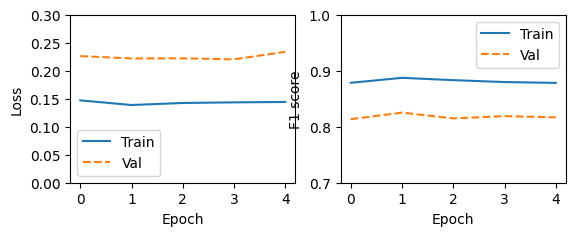

In [ ]:
plot_metrics(history)


### Test data evaluation

In [ ]:
final_model.evaluate(x_test, y_test)

170/170 [==============================] - 7s 40ms/step - loss: 7.0368 - f1_score: 5.2202e-04


[7.036821365356445, 0.0005220198072493076]

In [ ]:
## test
y_pred = final_model.predict(x_test, batch_size=batch_size)

43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step


In [ ]:
y_pred #this is softmax

array([[0.00099105, 0.07874712, 0.00191255, ..., 0.00031298, 0.00024392,
        0.00015207],
       [0.00099121, 0.07881789, 0.00191107, ..., 0.00031305, 0.00024386,
        0.00015204],
       [0.00099193, 0.07875391, 0.00190936, ..., 0.00031323, 0.00024369,
        0.00015226],
       ...,
       [0.00099199, 0.0787496 , 0.00190954, ..., 0.00031326, 0.00024372,
        0.00015227],
       [0.00099149, 0.07885849, 0.0019114 , ..., 0.00031289, 0.00024384,
        0.00015212],
       [0.00099125, 0.07881615, 0.0019111 , ..., 0.00031307, 0.00024387,
        0.00015205]], dtype=float32)

In [ ]:
np.max(y_pred)

0.9749351

In [ ]:
y_pred_c = np.array(list(map(lambda x: x==max(x), y_pred))).astype('float')

## Optimization

### dropout and kernel with GridSearch

In [ ]:
def build_model(hp):
    #Optimizer definer
    hp_drop = hp.Choice("Drop",values=[0., 0.2, 0.5])
    #hp_learning_rate = hp.Choice("Learning_rate", values=[0.001, 0.01])
    hp_kernel = hp.Choice("Kernel", values=[3, 5])

    model = build_final_model(y_train, k_n = hp_kernel , MP = True, PD = True, dropout_mlp = hp_drop) # error with 5
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=[F1Score("macro")])

    return model
seed  = 0
tuner = kt.GridSearch(
    hypermodel=build_model,
    objective="val_loss",
    #max_trials=2,
    #executions_per_trial=2,
    overwrite=True,
    directory="tuner_search",
    project_name="lr_units",
    seed=seed,
)

tuner.search_space_summary()

notes: 0.5 dropout is super bad
try 0.2 vs 0.1?
kernel 3 is better

Best val_loss So Far: 0.2931958734989166
Total elapsed time: 00h 26m 03s
{'Drop': 0.2, 'Kernel': 3}
Results summary
Results in tuner_search/lr_units
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0000 summary
Hyperparameters:
Drop: 0.2
Kernel: 3
Score: 0.2931958734989166

Trial 0002 summary
Hyperparameters:
Drop: 0.5
Kernel: 3
Score: 0.41525933146476746

Trial 0001 summary
Hyperparameters:
Drop: 0.2
Kernel: 5
Score: 0.4620615541934967

Trial 0003 summary
Hyperparameters:
Drop: 0.5
Kernel: 5
Score: 4.026015281677246
None

In [ ]:
tf.random.set_seed(seed)
np.random.seed(seed)

tun_model = tuner.search(x_train, y_train, epochs=20, batch_size=256, validation_data=(x_val, y_val))

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)
print(tuner.results_summary())

In [ ]:
tf.random.set_seed(seed)
np.random.seed(seed)

tun_model = tuner.search(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_val, y_val))

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)
print(tuner.results_summary())

Trial 4 Complete [00h 05m 55s]
val_loss: 4.026015281677246

Best val_loss So Far: 0.2931958734989166
Total elapsed time: 00h 26m 03s
{'Drop': 0.2, 'Kernel': 3}
Results summary
Results in tuner_search/lr_units
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0000 summary
Hyperparameters:
Drop: 0.2
Kernel: 3
Score: 0.2931958734989166

Trial 0002 summary
Hyperparameters:
Drop: 0.5
Kernel: 3
Score: 0.41525933146476746

Trial 0001 summary
Hyperparameters:
Drop: 0.2
Kernel: 5
Score: 0.4620615541934967

Trial 0003 summary
Hyperparameters:
Drop: 0.5
Kernel: 5
Score: 4.026015281677246
None


### learning rate scheduler

ExponentialDecay
PiecewiseConstantDecay
PolynomialDecay
InverseTimeDecay
CosineDecay
CosineDecayRestarts

In [ ]:
### scheduler

initial_learning_rate = 0.001
first_decay_steps = 1000 # samples / batch size = 16256 / 128 = 127

cosine_decay_scheduler = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps,
    t_mul=2.0, # derive initial learning rate of ith perior: period will roughly double with each restart
    m_mul=1.5, # derive initial learning rate of ith period
    alpha=0.01, # min lr value as a fraction of initial learning rate Assuming the initial learning rate to be 1e-3. If you want the final learning rate to be 1e-5, alpha should be 1e-2.
    name="SGDRDecay",
)

In [ ]:
# need to rerun this every time you want to restart the weights
model_cds = build_final_model(y_train, 3, MP = True, PD = True)

In [ ]:
model_cds.compile(optimizer=keras.optimizers.Adam(learning_rate = cosine_decay_scheduler),
              loss="categorical_crossentropy",
              metrics=[F1Score("macro")])

batch_size = 128
epochs = 300

In [ ]:
# dont run twice in the same minute because of folder name (see create_checkpoint_paths)

## create files
checkpoint_folder, checkpoint_path, epoch_checkpoint_path, metrics_path = create_checkpoint_paths()

## callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only = True,
                                                 save_best_only=True,
                                                 verbose=1)

#stop_early_callback = keras.callbacks.EarlyStopping(monitor="val_f1_score", mode='max', patience=10)

save_metrics_callback = SaveMetricsCallback(metrics_path)

lr_scheduler_callback = LearningRateHistory()

best_epoch_callback = BestEpochCallback(monitor='val_loss', checkpoint_path=epoch_checkpoint_path)


## model

#model_cds.save_weights(checkpoint_path_template.format(epoch=0))

start_time = time.time()
history = model_cds.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val), callbacks=[cp_callback, lr_scheduler_callback, save_metrics_callback, best_epoch_callback])
end_time = time.time()
elapsed_time = end_time - start_time

#model_cds.save(checkpoint_folder + 'full_model.h5')

with open(metrics_path, 'a') as f:
    f.write(f"Training time: {elapsed_time:.2f} seconds\n")
    f.write(f"Best epoch: {best_epoch_callback.best_epoch}\n")


Epoch 1/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - f1_score: 0.0024 - loss: 4.4102
Epoch 1: val_loss improved from inf to 4.06668, saving model to /content/drive/MyDrive/DLProject/cnn_models/weights_model_12_20:26/cp_model.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 45s 162ms/step - f1_score: 0.0024 - loss: 4.4086 - val_f1_score: 5.2177e-04 - val_loss: 4.0667
Epoch 2/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - f1_score: 0.0023 - loss: 4.1037
Epoch 2: val_loss did not improve from 4.06668
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - f1_score: 0.0023 - loss: 4.1036 - val_f1_score: 1.0876e-05 - val_loss: 8.4954
Epoch 3/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - f1_score: 0.0031 - loss: 4.0213
Epoch 3: val_loss improved from 4.06668 to 2.53264, saving model to /content/drive/MyDrive/DLProject/cnn_models/weights_model_12_20:26/cp_model.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - f1_score: 0.0032 - loss: 4.0193 - val_f1_score: 0.0205 - val_loss: 2.5326
Epoch 4/300


In [ ]:
print(best_epoch_callback.best_epoch)
learning_rates = lr_scheduler_callback.learning_rates
print(learning_rates)


plt.plot(range(1, len(lr_scheduler_callback.learning_rates) + 1), lr_scheduler_callback.learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()


4

In [ ]:
plot_metrics(history)

### architecture

In [ ]:
model_smaller = build_final_model(y_train, 3, dropout_mlp = 0.0, out_channels=[32, 64, 128], MP = True, PD = True)
model_larger = build_final_model(y_train, 3, dropout_mlp = 0.0, out_channels=[32, 64, 128, 256],  MP = True, PD = True)

In [ ]:
model_larger.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              loss="categorical_focal_crossentropy",
              metrics=[F1Score("macro")])

batch_size = 256
epochs = 50

In [ ]:
# dont run twice in the same minute because of folder name (see create_checkpoint_paths)

## create files
checkpoint_folder, checkpoint_path, epoch_checkpoint_path, metrics_path = create_checkpoint_paths()

## callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only = True,
                                                 save_best_only=True,
                                                 verbose=1)


save_metrics_callback = SaveMetricsCallback(metrics_path)

best_epoch_callback = BestEpochCallback(monitor='val_loss', checkpoint_path=epoch_checkpoint_path)


## model

start_time = time.time()
history = model_larger.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val), callbacks=[cp_callback, save_metrics_callback, best_epoch_callback])
end_time = time.time()
elapsed_time = end_time - start_time

with open(metrics_path, 'a') as f:
    f.write(f"Training time: {elapsed_time:.2f} seconds\n")
    f.write(f"Best epoch: {best_epoch_callback.best_epoch}\n")


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score: 0.0035 - loss: 4.4590
Epoch 1: val_loss improved from inf to 4.06721, saving model to /content/drive/MyDrive/DLProject/cnn_models/weights_model_13_20:31/cp_model.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - f1_score: 0.0035 - loss: 4.4555 - val_f1_score: 5.2177e-04 - val_loss: 4.0672
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score: 0.0023 - loss: 4.1022
Epoch 2: val_loss improved from 4.06721 to 4.05353, saving model to /content/drive/MyDrive/DLProject/cnn_models/weights_model_13_20:31/cp_model.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - f1_score: 0.0023 - loss: 4.1022 - val_f1_score: 5.2177e-04 - val_loss: 4.0535
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score: 0.0022 - loss: 4.0728
Epoch 3: val_loss improved from 4.05353 to 4.04075, saving model to /content/drive/MyDrive/DLProject/cnn_models/weights_model_13_20:31/cp_model.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 228s 4s/step - f1_score

In [ ]:
model_smaller.get_weights()

[]

In [ ]:
model_smaller.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              loss="categorical_focal_crossentropy",
              metrics=[F1Score("macro")])

batch_size = 256
epochs = 50

In [ ]:
# dont run twice in the same minute because of folder name (see create_checkpoint_paths)

## create files
checkpoint_folder, checkpoint_path, epoch_checkpoint_path, metrics_path = create_checkpoint_paths()

## callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only = True,
                                                 save_best_only=True,
                                                 verbose=1)


save_metrics_callback = SaveMetricsCallback(metrics_path)

best_epoch_callback = BestEpochCallback(monitor='val_loss', checkpoint_path=epoch_checkpoint_path)


## model

start_time = time.time()
history = model_smaller.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val), callbacks=[cp_callback, save_metrics_callback, best_epoch_callback])
end_time = time.time()
elapsed_time = end_time - start_time

with open(metrics_path, 'a') as f:
    f.write(f"Training time: {elapsed_time:.2f} seconds\n")
    f.write(f"Best epoch: {best_epoch_callback.best_epoch}\n")


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score: 0.0020 - loss: 1.0486
Epoch 1: val_loss improved from inf to 0.95139, saving model to /content/drive/MyDrive/DLProject/cnn_models/weights_model_13_21:42/cp_model.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - f1_score: 0.0020 - loss: 1.0476 - val_f1_score: 4.4986e-04 - val_loss: 0.9514
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score: 0.0047 - loss: 0.8971
Epoch 2: val_loss improved from 0.95139 to 0.60134, saving model to /content/drive/MyDrive/DLProject/cnn_models/weights_model_13_21:42/cp_model.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - f1_score: 0.0048 - loss: 0.8957 - val_f1_score: 0.0176 - val_loss: 0.6013
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score: 0.0397 - loss: 0.4424
Epoch 3: val_loss improved from 0.60134 to 0.30369, saving model to /content/drive/MyDrive/DLProject/cnn_models/weights_model_13_21:42/cp_model.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - f1_score: 0.

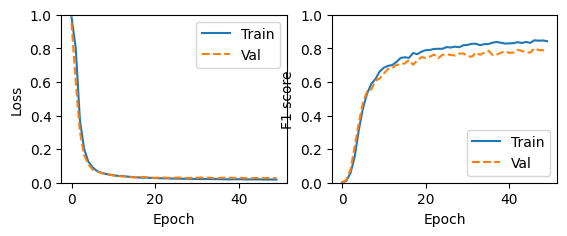

In [ ]:
plot_metrics(history)

In [ ]:
history.history['val_f1_score']

NameError: name 'history' is not defined

### loss function and dropout with gridsearch

In [ ]:
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy


In [ ]:
def build_model(hp):
    hp_drop = hp.Choice("Drop",values=[0., 0.2])
    hp_loss = hp.Choice("Loss_function", values=["categorical_crossentropy", "categorical_focal_crossentropy"])

    model = build_final_model(y_train, k_n = 3 , MP = True, PD = True, dropout_mlp = hp_drop)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=hp_loss,
              metrics=[F1Score("macro")])

    return model

seed  = 0
tuner = kt.GridSearch(
    hypermodel=build_model,
    objective="val_loss",
    #max_trials=2,
    #executions_per_trial=2,
    overwrite=True,
    directory="tuner_search",
    project_name="lr_units",
    seed=seed,
)

tuner.search_space_summary()

Search space summary
Default search space size: 2
Drop (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
Loss_function (Choice)
{'default': 'categorical_crossentropy', 'conditions': [], 'values': ['categorical_crossentropy', 'categorical_focal_crossentropy'], 'ordered': False}


In [ ]:
tun_model = tuner.search(x_train, y_train, epochs=50, batch_size=256, validation_data=(x_val, y_val))

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)
print(tuner.results_summary()) #know the model parameters

Trial 4 Complete [00h 16m 50s]
val_loss: 0.03384075313806534

Best val_loss So Far: 0.026582278311252594
Total elapsed time: 01h 09m 47s
{'Drop': 0.0, 'Loss_function': 'categorical_focal_crossentropy'}
Results summary
Results in tuner_search/lr_units
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0001 summary
Hyperparameters:
Drop: 0.0
Loss_function: categorical_focal_crossentropy
Score: 0.026582278311252594

Trial 0003 summary
Hyperparameters:
Drop: 0.2
Loss_function: categorical_focal_crossentropy
Score: 0.03384075313806534

Trial 0000 summary
Hyperparameters:
Drop: 0.0
Loss_function: categorical_crossentropy
Score: 0.22650451958179474

Trial 0002 summary
Hyperparameters:
Drop: 0.2
Loss_function: categorical_crossentropy
Score: 0.24502591788768768
None


## Interpretation

In [ ]:
conv_layers = [layer.name for layer in fullmodel.layers if layer.name.endswith("conv")]
conv_layers

In [ ]:
def get_layer_output(model, layer_name):
  """
  Used to analyze a model. Creates a model with the activation of a convolution layer as output.
  - model : Model to analyze
  - layer_name : Name of the layer to look for
  Return a model
  """
  return Model(model.inputs,
                 model.get_layer(layer_name).output)

def get_excitement(images, model, layer_name, filter_idx, batch_size=64):
  """
  Calculate the activation of a input image of each channel of one convolution
  layer of the CNN.
  - images : Images used to activate the layers of the network
  - model : Model to analyze
  - layer_name : Name of the layer to activate
  Return Activation values of the neuron in order
  """
  excitements = np.array([])
  get_activations = get_layer_output(model, layer_name)
  for i in range(0, len(images), batch_size):
      activations = get_activations(images[i : i + batch_size])[:, :, :, filter_idx]
      excitements = np.hstack([excitements, np.mean(np.abs(activations), axis=(1, 2))])
  return excitements

def get_top_exciting_instances(images, model,
                               layer_name, filter_idx, top=4):
    """
    Get the top images that most activate one the convolution layer of the CNN.
    - images : Images used to activate the layers of the network
    - model : Model to analyze
    - layer_name : Name of the layer to activate
    Return The index of the images, The activation value
    """
    excitements = get_excitement(images, model,
                                 layer_name, filter_idx)
    excitements_idx = np.argsort(excitements)[-top:][::-1]
    return excitements_idx, excitements[excitements_idx]

def show_exciting_images(images, model, layer_name, filter_idx, top=4):
    """
    Plot the top images that most activate one the convolution layer of the CNN.
    layers of the CNN.
    - images : Images used to activate the layers of the network
    - model : Model to analyze
    - layer_name : Name of the layer to activate
    """
    excitements_idx, excitements = get_top_exciting_instances(images, model, layer_name, filter_idx, top)
    rows_cols = int(np.ceil(np.sqrt(top)))
    fig, ax = plt.subplots(rows_cols, rows_cols, figsize=(2 * rows_cols, 2 * rows_cols))
    for i, excitement_idx in enumerate(excitements_idx):
        ax[i // rows_cols][i % rows_cols].imshow(images[excitement_idx])
    fig.tight_layout()
    plt.show()

def get_all_excitements (model, conv_layers, x_data):
  """
  Calculate the activation of a input image of each channel of all convolution
  layers of the CNN.
  - model : Model to analyze
  - conv_layers : List with the names of all the convolutional layer of the model
  - x_data : Images used to activate the layers of the network
  Return Activation values of the neuron in order
  """
  for i in range(len(conv_layers)):
    print(conv_layers[i])
    if i == 0 : A = get_excitement(x_data, model, conv_layers[i], 0)
    else :
      B = get_excitement(x_train, model, conv_layers[i], 0)
      A = np.concatenate((A,B))
    print(A.shape)
  return A

## Activated neurons

In [ ]:
model = fullmodel

In [ ]:
Activations = get_all_excitements (model, conv_layers, x_train)
plt.title("Activating neurons")
plt.plot(Activations)

In [ ]:
#Now for each class
Act_classes = []
for name in class_names:
  part = sep_sets[name]
  Act_classes.append(get_all_excitements (model, conv_layers, part))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Act_classes[0], label=class_names[0], color='red')
plt.plot(Act_classes[1], label=class_names[1], color='blue')
plt.plot(Act_classes[2], label=class_names[2], color='green')
plt.plot(Act_classes[3], label=class_names[3], color='orange')
plt.plot(Act_classes[4], label=class_names[4], color='purple')

plt.xticks(np.arange(0, np.max(Act_classes[0]) + 700, 700))
plt.title("Neurons activation per class")
plt.legend()
plt.show()

In [ ]:
#The first layer is the one that get more exiced by the images so we should analyze it

In [ ]:
def show_exciting_images(images, model, layer_name, filter_idx, name = "", top=9):
    """
    Plot the top images that activate the most a convolutional layer
    - images : Images used to activate the layers of the network
    - model : Model to analyze
    - layer_name : Name of the layer to activate
    - top : number of top images to show
    Return index of the top images
    """
    excitements_idx, excitements = get_top_exciting_instances(images, model, layer_name, filter_idx, top)
    rows_cols = int(np.ceil(np.sqrt(top)))
    fig, ax = plt.subplots(rows_cols, rows_cols, figsize=(2 * rows_cols, 2 * rows_cols))
    for i, excitement_idx in enumerate(excitements_idx):

        try :
          image = images[excitement_idx].numpy().astype("uint8")
          ax[i // rows_cols][i % rows_cols].set_title(f"{class_names[y_train[excitement_idx]]}")
        except :
          image = images[excitement_idx].astype("uint8")
        ax[i // rows_cols][i % rows_cols].imshow(image)

    fig.tight_layout()

    plt.show()


    return excitements_idx

In [ ]:
#Begin with the most representative images ¿what is the model paying attention too?
show_exciting_images(x_train, model, conv_layers[1], filter_idx=3)


In [ ]:
#Now do it per class
A1 = show_exciting_images(sep_sets['bbq'], model, conv_layers[1], filter_idx=3, name="bbq")

# Check the prediction at multiple levels

In [ ]:
#load the model
bestmodel = load_model('bestmodel.h5') #save the whole model

In [ ]:
#Get the indexes from predictions
y_pred = np.random.rand(len(y_test), 269) #Create data just to have something to work with
#y_pred = bestmodel.predict(x_test) # READ !!!!!! uncomment when want to test for real
pred_ind = np.argmax(y_pred, axis=1)
real_ind = np.argmax(y_test, axis=1)

In [ ]:
#Get the multilevel predictions
ml_real = []
ml_pred = []
for i in range(len(y_test)):
  #for real:
  s_real = filos[real_ind[i]].split(";")
  if len(s_real) == 6:
    gen = s_real[-1].split(" ")
    s_real = s_real[:-1] + [gen[0].replace("[","").replace("]","")] + s_real[-1:]
  ml_real.append(s_real)
  #for pred:
  s_pred = filos[pred_ind[i]].split(";")
  if len(s_pred) == 6:
    gen = s_pred[-1].split(" ")
    s_pred = s_pred[:-1] + [gen[0].replace("[","").replace("]","")] + s_pred[-1:]
  ml_pred.append(s_pred)

In [ ]:
#Get them on the right format
ml_real = np.array(ml_real).T
ml_pred = np.array(ml_pred).T
#List for better iteratation
ml_reals = ml_real.tolist()
ml_preds = ml_pred.tolist()

In [ ]:
#Get all the possible multilevel labels
ml_level = []
for i in range(len(filos)):
  s_level = filos[i].split(";")
  if len(s_level) == 6:
    gen = s_level[-1].split(" ")
    s_level = s_level[:-1] + [gen[0].replace("[","").replace("]","")] + s_level[-1:]
  ml_level.append(s_level)
ml_level = np.array(ml_level).T
ml_levels = ml_level.tolist()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

#Create an F1 evaluator
def f1_macro_score(y_true, y_pred, level_lab):
    label_encoder = LabelEncoder()
    y_true_encoded = label_encoder.fit_transform(level_lab)
    y_true_encoded = label_encoder.transform(y_true)
    y_pred_encoded = label_encoder.transform(y_pred)

    f1_scores = f1_score(y_true_encoded, y_pred_encoded, average=None)
    macro_f1 = sum(f1_scores) / len(f1_scores)

    return macro_f1

In [ ]:
# run f1_macro_score for each level of complexity
F1_levels = []
for level in range(7):
  F1_levels.append(f1_macro_score(ml_reals[level], ml_preds[level], ml_levels[level]))

In [ ]:
levels = ["Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"]
for i in range(7):
  print(f"For the level {levels[i]} the F1 score is: {F1_levels[i]}")

For the level Kingdom the F1 score is: 1.0
For the level Phylum the F1 score is: 0.3236446093588951
For the level Class the F1 score is: 0.1163704781306848
For the level Order the F1 score is: 0.026768047695146104
For the level Family the F1 score is: 0.014892659472888705
For the level Genus the F1 score is: 0.006183495514259274
For the level Species the F1 score is: 0.0009858384555240841
